# Imports

In [5]:
import pydot
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [6]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from keras.layers import dot
from tensorflow.keras.utils import plot_model

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Dataset

In [9]:
dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')
anime_df = pd.read_csv('../data/raw_data/anime.csv')
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

In [10]:
dataset.anime_id.nunique()

12106

In [11]:
dataset.user_id.nunique()

4035

# Order dataset by user_id and anime_id

In [12]:
anime_id_to_new_id = dict()
id = 1

In [13]:
%%time
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])


CPU times: user 1min 30s, sys: 369 ms, total: 1min 30s
Wall time: 1min 33s


In [14]:
%%time
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])


CPU times: user 1min 6s, sys: 8.53 ms, total: 1min 6s
Wall time: 1min 6s


In [15]:
dataset

,user_id,anime_id,rating
3,1,1,10
4,1,2,9
0,1,3,9
9,1,4,6
14,1,5,9
...,...,...,...
822308,4035,323,8
822416,4035,1486,7
822372,4035,1286,9
822305,4035,1302,7


In [16]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 12106
Number of users 4035


In [17]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


# Multi-layer Perceptron

In [18]:
from keras.layers import  BatchNormalization

latent_dim = 10

# Define inputs
anime_input = Input(shape=[1],name='anime-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
anime_embedding_mlp = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mlp')(anime_input)
anime_vec_mlp = Flatten(name='flatten-anime-mlp')(anime_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
anime_embedding_mf = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mf')(anime_input)
anime_vec_mf = Flatten(name='flatten-anime-mf')(anime_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)


2021-08-31 11:21:03.813715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-31 11:21:03.813791: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-31 11:21:03.813821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-31 11:21:03.814226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:

# MLP layers
concat = concatenate([anime_vec_mlp, user_vec_mlp], axis=1, name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([anime_vec_mf, user_vec_mf], axes=1, normalize=False, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=1, name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, anime_input], result)
model.compile(Adam(learning_rate=0.01), loss='mean_absolute_error',metrics=['mse'])



In [31]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

# model.fit(X_train, y_train, 
#           batch_size=16, 
#           epochs=1000, 
#           validation_split=0.3,
#           callbacks=[es])

Epoch 1/9
14393/14393 [==============================] - 147s 10ms/step - loss: 1.0274 - mse: 1.9381 - val_loss: 0.9978 - val_mse: 1.8477
Epoch 2/9
14393/14393 [==============================] - 138s 10ms/step - loss: 0.9814 - mse: 1.7770 - val_loss: 1.0034 - val_mse: 1.8142
Epoch 3/9
14393/14393 [==============================] - 203s 14ms/step - loss: 0.9574 - mse: 1.6989 - val_loss: 1.0078 - val_mse: 1.8201
Epoch 4/9
14393/14393 [==============================] - 129s 9ms/step - loss: 0.9304 - mse: 1.6226 - val_loss: 1.0183 - val_mse: 1.8315


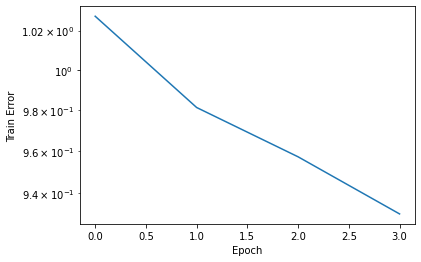

1.0026014132599537

In [32]:
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=9,validation_split=0.3,callbacks=[es])
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [34]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.functional.Functional at 0x7f4de87c7df0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [1.0273793935775757,
   0.9813965559005737,
   0.9574159979820251,
   0.930374801158905],
  'mse': [1.938114881515503,
   1.7770321369171143,
   1.6989171504974365,
   1.6226035356521606],
  'val_loss': [0.9977549910545349,
   1.0034184455871582,
   1.0077998638153076,
   1.0183348655700684],
  'val_mse': [1.8477169275283813,
   1.8142188787460327,
   1.8201158046722412,
   1.8315346240997314]},
 'params': {'verbose': 1, 'epochs': 9, 'steps': 14393},
 'epoch': [0, 1, 2, 3]}

In [39]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Val'], loc='best')
    
    ax[1].plot(history.history['mse'])
    ax[1].plot(history.history['val_mse'])
    ax[1].set_title('Model mse')
    ax[1].set_ylabel('mse')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0,3))
    if title:
        fig.suptitle(title)

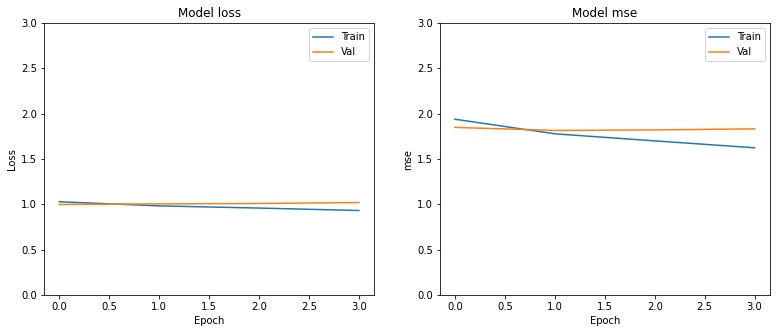

In [40]:
plot_loss_accuracy(history)